# Optimizing Model Prediction

In this project we're optimizing a model prediction of `LinearRegression()`. We'll be exploring several options like quadratic model to spline models. Here we'll be using a dataset of [Forest Fires](https://archive.ics.uci.edu/dataset/162/forest+fires).

In [4]:
# Read the dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fires = pd.read_csv('fires.csv')

In [5]:
fires.head()

,Unnamed: 0,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,1,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0
1,2,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0
2,3,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0
3,4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0
4,5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.0


In this project we'll be using columns of

* `temp` : Temperature: from 2.2 to 33.30 degrees Celcius, and
* `wind` : Wind speed: 0.40 to 9.40 km/h

Outcome of interest will be `area` : The burned area of the forest: 0.00 to 1090.84 ha.

In [6]:
fires_reference = fires[['temp', 'wind', 'area']]
reference_X = fires_reference[['temp', 'wind']]

In [7]:
from sklearn.linear_model import LinearRegression

# First option: Plain linear model -- `lm`
reference = LinearRegression()

In [8]:
fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  517 non-null    int64  
 1   X           517 non-null    int64  
 2   Y           517 non-null    int64  
 3   month       517 non-null    object 
 4   day         517 non-null    object 
 5   FFMC        469 non-null    float64
 6   DMC         496 non-null    float64
 7   DC          474 non-null    float64
 8   ISI         515 non-null    float64
 9   temp        496 non-null    float64
 10  RH          487 non-null    float64
 11  wind        482 non-null    float64
 12  rain        485 non-null    float64
 13  area        517 non-null    float64
dtypes: float64(9), int64(3), object(2)
memory usage: 56.7+ KB


## Data Processing

The dataset consists of a whole year with `month` ranging from `jan` to `dec`. We can categorize this even further to seasonal tendencies; most forest fires are happening in `summer`, we can categorize the months into `is_summer`. 

But before that, let's check on `area` distribution:

array([[<AxesSubplot:title={'center':'area'}>]], dtype=object)

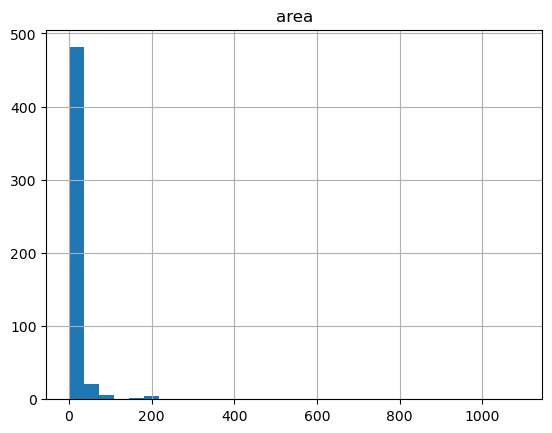

In [9]:
fires.hist('area', bins=30)

> The distribution is right-skewed--not bell-shaped. Also most values are near-zero. We can try `log-transform`ing the data.

array([[<AxesSubplot:title={'center':'log_area'}>]], dtype=object)

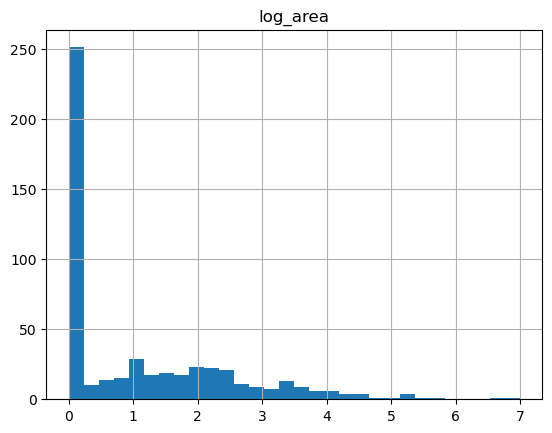

In [10]:
fires['log_area'] = np.log(fires['area'] + 1)
fires.hist('log_area', bins=30)

The transformation does not turn the distribution into a normal one--bell-shaped, but the data is spread out a bit more. We'll leave it for now. The near-zero value may mean that most fire don't spread to a forest-scale damage, so we would be mistaken in removing all of the rows.

Now onto the months: We can make a column of `is_summer`

In [11]:
fires['summer'] = fires['month'].apply(lambda x:
       1 if x in ['jun', 'jul', 'aug'] else 0)
fires.head()

,Unnamed: 0,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log_area,summer
0,1,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0,0.0,0
1,2,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0,0.0,0
2,3,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0,0.0,0
3,4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0,0.0,0
4,5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.0,0.0,0


We do have missing values on all numerical values in the dataset, including our target columns `temp` and `wind`. To complete the values, we'll do imputation using [`KNNImputer()`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html).

In [12]:
from sklearn.impute import KNNImputer

imp = KNNImputer(missing_values = np.nan, n_neighbors = 3)

fires_missing = fires[fires.columns[5:13]] # `FFMC` to `rain`
imputed = pd.DataFrame(imp.fit_transform(fires_missing), 
                       columns = fires.columns[5:13])
imputed

,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,86.2,26.200000,94.300000,5.1,16.6,51.0,6.700000,0.0
1,90.6,56.433333,669.100000,6.7,18.0,33.0,0.900000,0.0
2,90.6,43.700000,470.833333,6.7,14.6,33.0,1.300000,0.0
3,91.7,33.300000,77.500000,9.0,8.3,97.0,4.000000,0.2
4,89.3,51.300000,102.200000,9.6,11.4,99.0,4.333333,0.0
...,...,...,...,...,...,...,...,...
512,81.6,56.700000,665.600000,1.9,27.8,32.0,2.700000,0.0
513,81.6,56.700000,665.600000,1.9,21.9,71.0,5.800000,0.0
514,81.6,56.700000,665.600000,1.9,21.2,70.0,6.700000,0.0
515,94.4,146.000000,614.700000,11.3,25.6,42.0,4.000000,0.0


We've imputed the data. Let's check the distribution using `boxplot()`.

<AxesSubplot:>

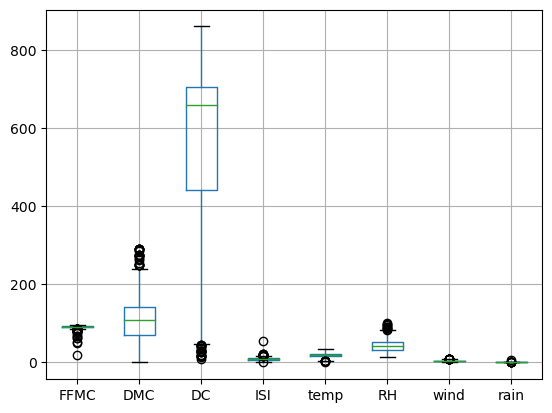

In [13]:
imputed.boxplot(column=['FFMC', 'DMC', 'DC', 'ISI', 
                        'temp', 'RH', 'wind', 'rain'])

We can see that the dots indicate a number of outliers on each column. Let's examine them in each one.

In [14]:
for col in imputed:
    
    quartiles = np.percentile(fires[col], [25, 50, 75])
    iqr = quartiles[2] - quartiles[0]
    lower_bound = quartiles[0] - (1.5 * iqr)
    upper_bound = quartiles[2] + (1.5 * iqr)
    num_outliers = sum( (imputed[col] < lower_bound) & 
                        (imputed[col] > upper_bound) )

    print(f'Number of outliers in {col} : {num_outliers}')

Number of outliers in FFMC : 0
Number of outliers in DMC : 0
Number of outliers in DC : 0
Number of outliers in ISI : 0
Number of outliers in temp : 0
Number of outliers in RH : 0
Number of outliers in wind : 0
Number of outliers in rain : 0


Despite the number of outliers in `boxplot()`, we don't get any outliers from the calculations. In this case, we'll leave the dataset as is.

Now we've completed the missing values, we can standardize the value and then add `summer` to the dataset. Since we're only dealing with numerical values in this regression model and we've categorized `summer`, we're only taking these data for the model.

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(imputed)
scaled = pd.DataFrame(scaled, columns = fires.columns[5:13])

final = pd.concat([fires['summer'], scaled], axis=1)


final

,summer,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,0,-0.812283,-1.335942,-1.846711,-0.860187,-0.398187,0.418726,1.514159,-0.073268
1,0,-0.010735,-0.859009,0.509582,-0.508736,-0.155493,-0.715565,-1.761003,-0.073268
2,0,-0.010735,-1.059878,-0.303178,-0.508736,-0.744894,-0.715565,-1.535130,-0.073268
3,0,0.189652,-1.223939,-1.915580,-0.003526,-1.837021,3.317471,-0.010485,0.603155
4,0,-0.247556,-0.939988,-1.814327,0.128267,-1.299625,3.443503,0.177742,-0.073268
...,...,...,...,...,...,...,...,...,...
512,1,-1.650265,-0.854803,0.495235,-1.563087,1.543370,-0.778581,-0.744573,-0.073268
513,1,-1.650265,-0.854803,0.495235,-1.563087,0.520585,1.679050,1.005944,-0.073268
514,1,-1.650265,-0.854803,0.495235,-1.563087,0.399238,1.616034,1.514159,-0.073268
515,1,0.681511,0.553912,0.286579,0.501683,1.161993,-0.148419,-0.010485,-0.073268


## Subset Selection

We've processed the data, now we need to *select* the best *features* for the model.

In [16]:
from sklearn.feature_selection import SequentialFeatureSelector

y = fires['log_area']

# Instantiate the class
sfs_model1 = LinearRegression()
sfs_model2 = LinearRegression()
sfs_model3 = LinearRegression()

# Apply SequentialFeatureSelector: Forward Selection
forward2 = SequentialFeatureSelector(
    estimator=sfs_model1, n_features_to_select=2, direction='forward')

forward4 = SequentialFeatureSelector(
    estimator=sfs_model2, n_features_to_select=4, direction='forward')

forward6 = SequentialFeatureSelector(
    estimator=sfs_model3, n_features_to_select=6, direction='forward')

# Fit dataset into the models
forward2.fit(final, y)
forward4.fit(final, y)
forward6.fit(final, y)

print(f'Features selected in 2 feature model - Forward Selection: \
{forward2.get_feature_names_out()}')
print(f'Features selected in 4 feature model - Forward Selection: \
{forward4.get_feature_names_out()}')
print(f'Features selected in 6 feature model - Forward Selection: \
{forward6.get_feature_names_out()}')

Features selected in 2 feature model - Forward Selection: ['FFMC' 'DC']
Features selected in 4 feature model - Forward Selection: ['FFMC' 'DC' 'RH' 'wind']
Features selected in 6 feature model - Forward Selection: ['summer' 'FFMC' 'DC' 'ISI' 'RH' 'wind']


In [17]:
# Apply SequentialFeatureSelector: Forward Selection
backward2 = SequentialFeatureSelector(
    estimator=sfs_model1, n_features_to_select=2, direction='backward')

backward4 = SequentialFeatureSelector(
    estimator=sfs_model2, n_features_to_select=4, direction='backward')

backward6 = SequentialFeatureSelector(
    estimator=sfs_model3, n_features_to_select=6, direction='backward')

# Fit dataset into the models
backward2.fit(final, y)
backward4.fit(final, y)
backward6.fit(final, y)

print(f'Features selected in 2 feature model - Backward Selection: \
{backward2.get_feature_names_out()}')
print(f'Features selected in 4 feature model - Backward Selection: \
{backward4.get_feature_names_out()}')
print(f'Features selected in 6 feature model - Backward Selection: \
{backward6.get_feature_names_out()}')

Features selected in 2 feature model - Backward Selection: ['DC' 'wind']
Features selected in 4 feature model - Backward Selection: ['FFMC' 'DC' 'RH' 'wind']
Features selected in 6 feature model - Backward Selection: ['summer' 'FFMC' 'DC' 'ISI' 'RH' 'wind']


From both forward and backward selection, it seems like `DC`, `wind`, and `FFMC` seem to be top 3 most impactful on predicting `log_area`.

## Developing More Candidates

Fires have many factors that can increase the `area` damage. ... We can try using regularized models.



In [18]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(alphas = np.linspace(1, 10000, num=1000))
lasso = LassoCV(alphas = np.linspace(1, 10000, num=1000))

ridge.fit(final, y)
lasso.fit(final, y)

print('Ridge tuning parameter: ', ridge.alpha_)
print('Lasso tuning parameter: ', lasso.alpha_)

print('Ridge coefficients: ', ridge.coef_)
print('Lasso coefficients: ', lasso.coef_)

Ridge tuning parameter:  1372.2342342342342
Lasso tuning parameter:  10000.0
Ridge coefficients:  [-0.01455017  0.01311215  0.02006457  0.02004741 -0.01073465  0.01297049
 -0.01489714  0.02670554  0.00816103]
Lasso coefficients:  [-0.  0.  0.  0. -0.  0. -0.  0.  0.]


Regularized models forcing the less-correlated to near-zero or zero. And we can see LASSO coefficients result in extreme zero in all coefficients--we can't take one feature for the model. We'll pick `RidgeCV()` and adjust the alpha parameters a little bit. 

## K-Fold Cross-Validation

Let's evaluate the model using k-fold cross-validation. K-Fold divides test set into k parts, and leaving the other entries as training sets. And then k iterations are made for each segments--leaving a better accuracy check on the used model.

In [20]:
# Reassigning forward and backward selection,
#     and fitting it with selected features beforehand.

fw2_model = LinearRegression()
fw2_model.fit(final[forward2.get_feature_names_out()], y)

fw4_model = LinearRegression()
fw4_model.fit(final[forward4.get_feature_names_out()], y)

fw6_model = LinearRegression()
fw6_model.fit(final[forward6.get_feature_names_out()], y)

bw2_model = LinearRegression()
bw2_model.fit(final[backward2.get_feature_names_out()], y)

bw4_model = LinearRegression()
bw4_model.fit(final[backward4.get_feature_names_out()], y)

bw6_model = LinearRegression()
bw6_model.fit(final[backward6.get_feature_names_out()], y)

LinearRegression()

In [25]:
from sklearn.model_selection import cross_val_score

# 0: Cross-Validation using plain reference = LinearRegression()
ref_cv = cross_val_score(reference, final[['wind', 'temp']], y,
                         cv = 5, scoring='neg_mean_squared_error')

# 1-3: Cross-Validation using forward selection -- 2, 4, and 6
fw2_cv = cross_val_score(fw2_model, final[forward2.get_feature_names_out()], y,
                         cv = 5, scoring='neg_mean_squared_error')

fw4_cv = cross_val_score(fw4_model, final[forward4.get_feature_names_out()], y,
                         cv = 5, scoring='neg_mean_squared_error')

fw6_cv = cross_val_score(fw6_model, final[forward6.get_feature_names_out()], y,
                         cv = 5, scoring='neg_mean_squared_error')

# 4-6: Cross-Validation using backward selection -- 2, 4, and 6
bw2_cv = cross_val_score(bw2_model, final[backward2.get_feature_names_out()], y,
                         cv = 5, scoring='neg_mean_squared_error')

bw4_cv = cross_val_score(bw4_model, final[backward4.get_feature_names_out()], y,
                         cv = 5, scoring='neg_mean_squared_error')

bw6_cv = cross_val_score(bw6_model, final[backward6.get_feature_names_out()], y,
                         cv = 5, scoring='neg_mean_squared_error')

# 7: Cross-Validation using RidgeCV
ridge_cv = cross_val_score(ridge, final, y,
                           cv = 5, scoring='neg_mean_squared_error')

In [26]:
print('Reference Model, avg_test MSE: ', np.mean(ref_cv),
      'SD: ', np.std(ref_cv))

print('Forward-2 Model, avg_test MSE: ', np.mean(fw2_cv),
      'SD: ', np.std(fw2_cv))
print('Forward-4 Model, avg_test MSE: ', np.mean(fw4_cv),
      'SD: ', np.std(fw6_cv))
print('Forward-6 Model, avg_test MSE: ', np.mean(fw6_cv),
      'SD: ', np.std(fw6_cv))

print('Backward-2 Model, avg_test MSE: ', np.mean(bw2_cv),
      'SD: ', np.std(bw2_cv))
print('Backward-4 Model, avg_test MSE: ', np.mean(bw4_cv),
      'SD: ', np.std(bw6_cv))
print('Backward-6 Model, avg_test MSE: ', np.mean(bw6_cv),
      'SD: ', np.std(bw6_cv))

Reference Model, avg_test MSE:  -2.204650013004116 SD:  1.060040355378637
Forward-2 Model, avg_test MSE:  -2.1735431721198535 SD:  1.0208083278697586
Forward-4 Model, avg_test MSE:  -2.193528106772711 SD:  1.0123323877770343
Forward-6 Model, avg_test MSE:  -2.2397225539348753 SD:  1.0123323877770343
Backward-2 Model, avg_test MSE:  -2.173357302739327 SD:  1.0038109503795958
Backward-4 Model, avg_test MSE:  -2.193528106772711 SD:  1.0123323877770343
Backward-6 Model, avg_test MSE:  -2.2397225539348753 SD:  1.0123323877770343


## Examining Model Weakness

We've found that `Backward-2`.has the best model used on this dataset. We can look for how this model predicts the dataset compared to the original test set.

In [ ]:
y_test_bw2 = bw2_model.predict(X_test, y_test)



With the mean squared error (MSE) across the models, `Backward-2` model has the least MSE. This is applied on `y = fires['log_area']`, so this suggests that the predictions are off by a magnitude of about 2. On the surface, this suggests that the models overall are not good predictors. 

However, with the extreme-skewed distribution of `log_area`, this outcome doesn't end up well for the application of linear models in machine learning. This could showcase that machine learning is not a universal fix. The prediction could become difficult when the dataset is not fulfilling the fundamental requirements of the model.